In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from sklearn import svm
from keras.datasets import imdb

2023-06-15 13:23:25.261906: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 13:23:25.514220: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 13:23:25.515877: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 13:23:26.780103: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load the dataset

In [45]:
# Use the default parameters to keras.datasets.imdb.load_data
start_char = 1
oov_char = 2
index_from = 3
vocab_size = 30000

(x_train, y_train), (x_test, y_test) = imdb.load_data(
    path="imdb.npz",
    num_words=vocab_size,
    skip_top=10,
    maxlen=None,
    seed=113,
    start_char=start_char,
    oov_char=oov_char,
    index_from=index_from,
)

print(x_train.shape, x_test.shape)

# Retrieve the word index file mapping words to indices
word_index = imdb.get_word_index()
# Reverse the word index to obtain a dict mapping indices to words
# And add `index_from` to indices to sync with `x_train`
inverted_word_index = dict(
    (i + index_from, word) for (word, i) in word_index.items()
)
# Update `inverted_word_index` to include `start_char` and `oov_char`
# inverted_word_index[start_char] = "[START]"
# inverted_word_index[oov_char] = "[OOV]"
# Decode the first sequence in the dataset
# decoded_sequence = " ".join(inverted_word_index[i] for i in x_train[2])
# decoded_sequence

(25000,) (25000,)


Turns out that the word indexing is almost in the same order as the word's frequency

In [7]:
flat_array = np.concatenate(x_train)

# Count the frequencies of each integer
unique_values, value_counts = np.unique(flat_array, return_counts=True)

# Sort the integers based on their frequencies in descending order
sorted_indices = np.argsort(value_counts)[::-1]

# Retrieve the integers with the highest frequencies
most_frequent_integers = unique_values[sorted_indices]

print(most_frequent_integers[0:10])
# Print the words corresponding to the most frequent integers
for i in most_frequent_integers[0:10]:
  print(inverted_word_index[i])

[ 4  5  6  7  8  9 10 11 12 13]
the
and
a
of
to
is
br
in
it
i


In [4]:
word_index["[START]"] = 1
word_index["[OOV]"] = 2

In [29]:
def extract_bow_feature_vectors(reviews, word_by_indices, binarize=False):
    """
    Args:
        `reviews` - a list of natural language strings
        `indices_by_word` - a dictionary of uniquely-indexed words.
    Returns:
        a matrix representing each review via bag-of-words features.  This
        matrix thus has shape (n, m), where n counts reviews and m counts words
        in the dictionary.
    """

    feature_matrix = np.zeros([len(reviews), vocab_size], dtype=np.float32)
    for i, word_indices in enumerate(reviews):
        for word_index in word_indices:
            if word_index not in word_by_indices : continue
            elif binarize:
                feature_matrix[i, word_index] = 1
            elif not binarize:
                feature_matrix[i, word_index] += 1
    print(feature_matrix[1][1:10])
    return feature_matrix   


In [46]:
train_size = 20000
test_size = 2000
feature_matrix_train = extract_bow_feature_vectors(x_train[:train_size], inverted_word_index, binarize=False)
feature_matrix_test = extract_bow_feature_vectors(x_test[:test_size], inverted_word_index, binarize=False)

[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]


## NN

In [7]:
import torch
import torch.autograd as autograd
import torch.nn.functional as F
import torch.nn as nn

In [24]:
def batchify_data(x_data, y_data, batch_size):
    """Takes a set of data points and labels and groups them into batches."""
    # Only take batch_size chunks (i.e. drop the remainder)
    N = int(len(x_data) / batch_size) * batch_size
    batches = []
    for i in range(0, N, batch_size):
        batches.append({
            'x': x_data[i:i+batch_size],
            'y': y_data[i:i+batch_size]})
    return batches

def compute_accuracy(predictions, y):
    """Computes the accuracy of predictions against the gold labels, y."""
    return np.mean(np.equal(predictions.numpy(), y))

In [49]:
# create batches for SGD
batch_size = 32
train_batches = batchify_data(feature_matrix_train, y_train[:train_size], batch_size)
test_batches = batchify_data(feature_matrix_test, y_test[:test_size], batch_size)

In [50]:
feature_matrix_train.shape, train_batches[0]["x"].shape, train_batches[0]["y"].shape, len(train_batches), 

((20000, 30000), (32, 30000), (32,), 625)

In [33]:
def run_epoch(data, model, optimizer):
    """Train model for one pass of train data, and return loss, acccuracy"""
    # Gather losses
    losses = []
    batch_accuracies = []

    # If model is in train mode, use optimizer.
    is_training = model.training

    # Iterate through batches
    for batch in data:#tqdm(data):
        # Grab x and y
        x, y = batch['x'], batch['y']

        # Get output predictions
        out = model(torch.tensor(x, dtype = torch.float32))

        # Predict and store accuracy
        predictions = torch.argmax(out, dim=1)
        batch_accuracies.append(compute_accuracy(predictions, y))

        # Compute loss
        loss = F.cross_entropy(out, torch.tensor(y, dtype=torch.long)) #+ 0.1*sum(torch.norm(p) for p in model.parameters())
        losses.append(loss.data.item())

        # If training, do an update.
        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Calculate epoch level scores
    avg_loss = np.mean(losses)
    avg_accuracy = np.mean(batch_accuracies)
    return avg_loss, avg_accuracy

def train_model(train_data, dev_data, model, lr=0.1, momentum=0.1, nesterov=False, n_epochs=30):
    """Train a model for N epochs given data and hyper-params."""
    # We optimize with SGD
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=nesterov)
    epochs_i = []
    losses_i = []
    val_losses_i = []
    val_accs_i = []

    for epoch in range(1, n_epochs+1):
        print("-------------\nEpoch {}:\n".format(epoch))

        # Run **training***
        loss, acc = run_epoch(train_data, model.train(), optimizer)
        print('Train loss: {:.6f} | Train accuracy: {:.6f}'.format(loss, acc))
        losses_i.append(loss)
        epochs_i.append(epoch)
        # Run **validation**
        val_loss, val_acc = run_epoch(dev_data, model.eval(), optimizer)
        val_losses_i.append(val_loss)
        val_accs_i.append(val_acc)
        print('Val loss:   {:.6f} | Val accuracy:   {:.6f}'.format(val_loss, val_acc))
        # Save model
        torch.save(model, "/notebooks/Sentiment_analysis_IMDB.pt")
    return losses_i, val_losses_i, val_accs_i, epochs_i

In [73]:
#################################
## Model specification TODO
model = nn.Sequential(
          nn.Linear(feature_matrix_test.shape[1], 128),
          nn.Tanh(),
          nn.Linear(128, 128),
          nn.Tanh(),
          nn.Linear(128, 128),
          nn.Tanh(),
          nn.Linear(128, 2)
        )
##################################
model

Sequential(
  (0): Linear(in_features=30000, out_features=128, bias=True)
  (1): Tanh()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): Tanh()
  (4): Linear(in_features=128, out_features=128, bias=True)
  (5): Tanh()
  (6): Linear(in_features=128, out_features=2, bias=True)
)

In [58]:
# train the model
losses_i, val_losses_i, val_accs, epochs_i = train_model(train_batches, test_batches, model, lr=0.001, momentum = 0.9, nesterov=True, n_epochs = 20)

# # Evaluate the model on test data
loss, accuracy = run_epoch(test_batches, model.eval(), None)

print ("Loss on test set:"  + str(loss) + " Accuracy on test set: " + str(accuracy))

-------------
Epoch 1:

Train loss: 2.637131 | Train accuracy: 0.664350
Val loss:   2.411405 | Val accuracy:   0.762601
-------------
Epoch 2:

Train loss: 2.250442 | Train accuracy: 0.802350
Val loss:   2.096127 | Val accuracy:   0.834173
-------------
Epoch 3:

Train loss: 1.989326 | Train accuracy: 0.856200
Val loss:   1.891566 | Val accuracy:   0.862399
-------------
Epoch 4:

Train loss: 1.787427 | Train accuracy: 0.880150
Val loss:   1.716459 | Val accuracy:   0.875000
-------------
Epoch 5:

Train loss: 1.610085 | Train accuracy: 0.893450
Val loss:   1.558878 | Val accuracy:   0.878528
-------------
Epoch 6:

Train loss: 1.450321 | Train accuracy: 0.902900
Val loss:   1.415925 | Val accuracy:   0.879536
-------------
Epoch 7:

Train loss: 1.306636 | Train accuracy: 0.908650
Val loss:   1.287262 | Val accuracy:   0.882560
-------------
Epoch 8:

Train loss: 1.180266 | Train accuracy: 0.912700
Val loss:   1.174305 | Val accuracy:   0.884073
-------------
Epoch 9:

Train loss: 1.07

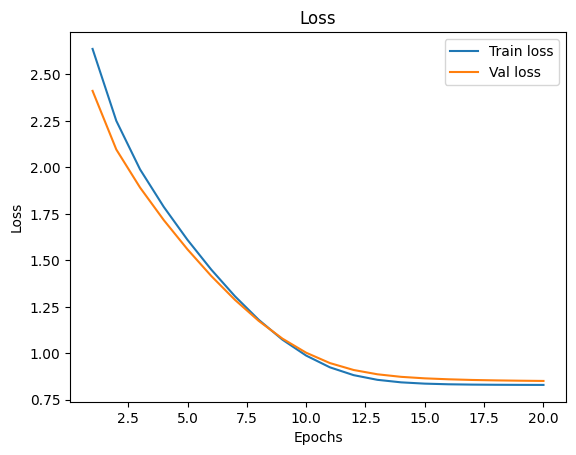

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(epochs_i, losses_i, label = "Train loss")
plt.plot(epochs_i, val_losses_i, label = "Val loss")
plt.legend()
plt.show()

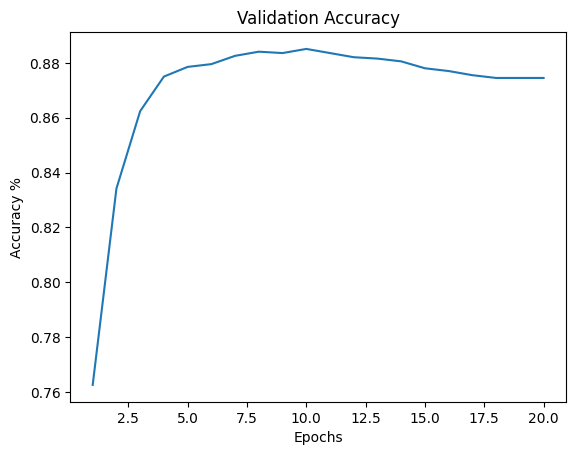

In [79]:
plt.figure()
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.plot(epochs_i, val_accs)
plt.show()

In [72]:
stepi = []
lossi = []

In [74]:
import random
lr = 0.001
momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True)

for i in range(1000):
  # minibatch construct
  # forward pass
  ix = random.randint(0,len(train_batches)-1)
  out = model(torch.tensor(train_batches[ix]['x'], dtype= torch.float32))
  # print(out.shape)
  loss = F.cross_entropy(out, torch.tensor(train_batches[ix]['y'], dtype= torch.long)) + 0.1 * sum(torch.norm(p) for p in model.parameters())
  
  #update
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  # scheduler.step()

  stepi.append(i)
  lossi.append(loss.log10().data.item())

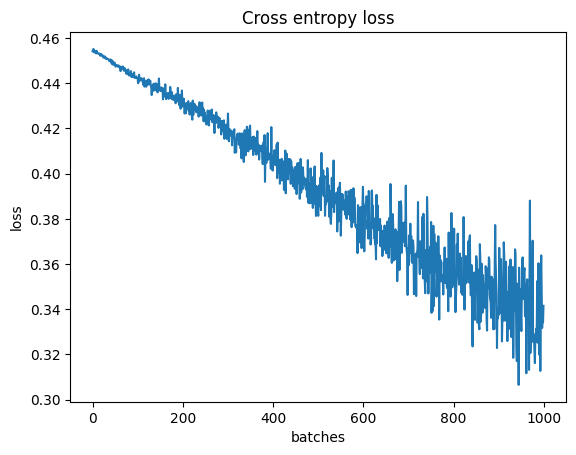

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.title("Cross entropy loss")
plt.ylabel("loss")
plt.xlabel("batches")
plt.plot(stepi, lossi)